## Device
Adjust your paths


In [2]:
shared_folder_Path = "//media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/ABONA_MEENA/shared"[:-6]
path_model = "/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/ABONA_MEENA/ⲯⲯⲯⲯⲯ/6_CycleGAN/model/"
paths_names = "/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/0_Data/Old_IXI/names-shared/"
data_path = '/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/0_Data/Old_IXI/'

In [3]:
import sys,os, glob
sys.path.insert(1,shared_folder_Path)

try:
    os.mkdir(path_model)
except:
    pass

import pickle
with open (paths_names+'train_Names.pkl', 'rb') as fp:
    train_images = pickle.load(fp)
with open (paths_names+'test_Names.pkl', 'rb') as fp:
    test_images = pickle.load(fp)

paths_train = [data_path+'IXI_T2_Train/IXI_T2_Train/'+i for i in train_images][:30000]
paths_test = [data_path+'IXI_T2_Test/IXI_T2_Test/'+i for i in    test_images][:]

device = "cuda"

## Import

In [4]:
%load_ext autoreload
%autoreload 2

import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import random
from tqdm import tqdm
from shared.plot import plot_2_Imgs, plot_3_Imgs, plot_4_Imgs, plot_Img
from shared.ssim import SSIM
ssim_calc = SSIM()

def get_n_params( model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn

    return pp


# Deterministic for spectral norm
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

def init_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(0)
    # no change in alg
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True)
init_seeds(42)

## Data

In [5]:
import pywt
import albumentations as A
aug = A.Resize(256, 256, p=1)

def FREQ_WaveLet(Imgall):
    Los = []; Highs = []
    try:
        Imgall = Imgall.cpu().detach()
    except:
        pass
    for Img in Imgall:
        image = Img[0]
        LL, (LH, HL, HH) = pywt.dwt2(image, "db2")
        LowImg = aug(image=LL)['image']
        
        mix = LH+ HL+ HH
        HighImg = aug(image=mix)['image']

        Los.append(torch.tensor(LowImg)[None])
        Highs.append(torch.tensor(HighImg)[None])
    return torch.stack(Los), torch.stack(Highs)

/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/ABONA_MEENA/VENV_FASTMRI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/ABONA_MEENA/VENV_FASTMRI/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
from torch.utils.data import Dataset, DataLoader
class MRIDataset(Dataset):
    def __init__(self, imgs_paths):
        self.imgs_paths = imgs_paths
    
    def __len__(self):
        return len(self.imgs_paths)

    def norm(self,arr):
        arr = 2*((arr - arr.min()) / (arr.max()-arr.min()))-1
        return arr
    
    def norm_0_1(self,arr):
        arr = ((arr - arr.min()) / (arr.max()-arr.min()))
        return arr

    def __getitem__(self, index):
        Main_Artifact_path = self.imgs_paths[index]
        arr = torch.load(Main_Artifact_path, weights_only=True).type(torch.float32) # convert to CNN input type
        
        Img_arr = arr[0]
        LowFreqArr,HighFreqArr = FREQ_WaveLet(Img_arr[None][None])
        LowFreqArr,HighFreqArr = LowFreqArr[0,0],HighFreqArr[0,0]
        LowFreqArr,HighFreqArr = self.norm_0_1(LowFreqArr),self.norm_0_1(HighFreqArr)

        Img_artifact = arr[1]
        LowFreqartifact,HighFreqartifact = FREQ_WaveLet(Img_artifact[None][None])
        LowFreqartifact,HighFreqartifact = LowFreqartifact[0,0],HighFreqartifact[0,0]
        LowFreqartifact,HighFreqartifact = self.norm_0_1(LowFreqartifact),self.norm_0_1(HighFreqartifact)

        num_diff = 6

        # Priors
        num =  int(Main_Artifact_path[ Main_Artifact_path.find("slice")+num_diff:Main_Artifact_path.find(".pt")])
        path_aft = Main_Artifact_path[:Main_Artifact_path.find("slice")+num_diff] + str(num+1) + ".pt"
        path_bef = Main_Artifact_path[:Main_Artifact_path.find("slice")+num_diff] + str(num-1) + ".pt"
        
        try:
            bef_art = torch.load(path_bef, weights_only=True).type(torch.float32)[1]
        except:
            bef_art = Img_artifact

        try:
            aft_art = torch.load(path_aft, weights_only=True).type(torch.float32)[1]
        except:
            aft_art = Img_artifact

        LowFreq_bef_art,HighFreq_bef_art = FREQ_WaveLet(bef_art[None][None])
        LowFreq_bef_art,HighFreq_bef_art = LowFreq_bef_art[0,0],HighFreq_bef_art[0,0]
        LowFreq_bef_art,HighFreq_bef_art = self.norm_0_1(LowFreq_bef_art),self.norm_0_1(HighFreq_bef_art)

        LowFreq_aft_art,HighFreq_aft_art = FREQ_WaveLet(aft_art[None][None])
        LowFreq_aft_art,HighFreq_aft_art = LowFreq_aft_art[0,0],HighFreq_aft_art[0,0]
        LowFreq_aft_art,HighFreq_aft_art = self.norm_0_1(LowFreq_aft_art),self.norm_0_1(HighFreq_aft_art)

        aft_art = self.norm(aft_art)
        bef_art = self.norm(bef_art)
        Img_arr = self.norm(Img_arr)
        Img_artifact = self.norm(Img_artifact)
        return  {"Arr":Img_arr[None,...], "Art":Img_artifact[None,...],\
                "LowFreqArr":LowFreqArr[None,...],"HighFreqArr":HighFreqArr[None,...],\
                "LowFreqArt":LowFreqartifact[None,...],"HighFreqArt":HighFreqartifact[None,...],
                 "path":Main_Artifact_path,
                "befArt":bef_art[None,...], "aftArt":aft_art[None,...],
                "LowFreq_bef_art":LowFreq_bef_art[None,...], "HighFreq_befArt":HighFreq_bef_art[None,...],
                "LowFreq_aft_art":LowFreq_aft_art[None,...], "HighFreq_aft_art":HighFreq_aft_art[None,...]}


dataset_train = MRIDataset(paths_train)
dataset_val = MRIDataset(paths_test)

print(len(dataset_train), len(dataset_val))

30000 12960


In [7]:
batch_size = 8

dataloaders = dict()
dataloaders['train'] = DataLoader(dataset_train, batch_size=batch_size,
                                   shuffle=True, pin_memory=True)
dataloaders['val'] = DataLoader(dataset_val, batch_size=batch_size,
                                shuffle=False, pin_memory=True)

tensor(-1.) tensor(1.)
tensor(-1.) tensor(1.)
tensor(0.) tensor(1.)
PSNR:  20.830114364624023
PSNR:  -0.5789288282394409
GV: 0.478152334690094
GV: 0.32102060317993164
haar1: tensor([[0.4173]])
haar2: tensor([[0.2778]])


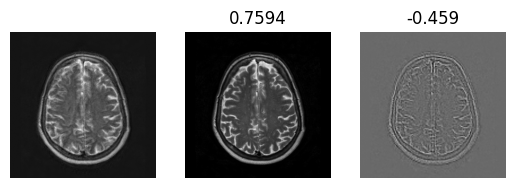

PSNR:  28.211278915405273
PSNR:  28.258155822753906
GV: 0.09521054476499557
GV: 0.0905919298529625
haar1: tensor([[0.5596]])
haar2: tensor([[0.5545]])


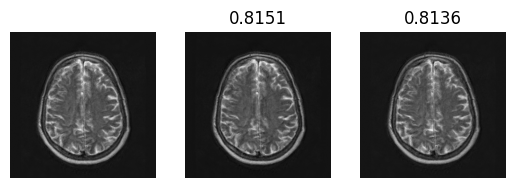

In [8]:
s = random.randint(0,len(dataset_val))
sample = dataset_val[s]

print(sample['Arr'][0].min(), sample['Arr'][0].max())
print(sample['Art'][0].min(), sample['Art'][0].max())
print(sample['HighFreqArt'][0].min(), sample['HighFreqArt'][0].max())
plot_3_Imgs(sample['Art'][0], sample['Arr'][0],sample['HighFreqArt'][0],rotate=True)
plot_3_Imgs(sample['Art'][0], sample['befArt'][0], sample['aftArt'][0],rotate=True)

## Model

/tmp/ipykernel_58015/831138266.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG_A = torch.load('/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/ABONA_MEENA/ⲯⲯⲯⲯⲯ/6_Cy

initialize network with normal
54407809
5881
Method 1
0.648226797580719
0.6355921030044556
Method 2
tensor(18.8165)
PSNR:  17.83759880065918
PSNR:  20.714006423950195
GV: 1.3996367454528809
GV: 1.0659006834030151
haar1: tensor([[0.3331]])
haar2: tensor([[0.3504]])


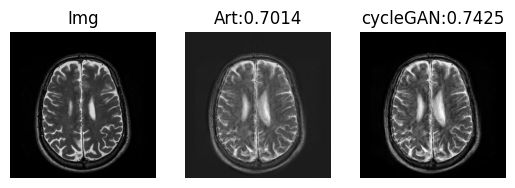

In [12]:
device = "cpu"
from networks import *
netG_A = torch.load('/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/ABONA_MEENA/ⲯⲯⲯⲯⲯ/6_CycleGAN/model_final/48_netG_A_model.pt','cpu')#define_G(input_nc=1,output_nc=1,ngf=64,netG='unet_256')
netG_B = define_G(input_nc=1,output_nc=1,ngf=64,netG='unet_256')
netG_A = netG_A.to(device=device)
netG_B = netG_B.to(device=device)
print(get_n_params(netG_A))

p = 5881#random.randint(0,len(dataset_val))
print(p)
sample= dataset_val[p]

with torch.no_grad():
    real_A = sample['Art'][None].to(device)
    real_B = sample['Arr'][None].to(device)
    fake_B = netG_A(real_A)
    rec_A  = netG_B(fake_B)
    fake_A = netG_B(real_B)
    rec_B = netG_A(fake_A)

    # 1. ssim the high freq
    print("Method 1")
    print(float(ssim_calc(FREQ_WaveLet(real_B)[1],FREQ_WaveLet(real_A)[1])))
    print(float(ssim_calc(FREQ_WaveLet(real_B)[1],FREQ_WaveLet(fake_B)[1])))

    # 2. Mse fft : https://arxiv.org/pdf/2108.05054 p.5
    print("Method 2")
    criterion = torch.nn.L1Loss()
    label_fft1 = torch.fft.fft2(real_B)
    pred_fft1 = torch.fft.fft2(fake_B)
    f1 = criterion(pred_fft1, label_fft1)
    print(f1)


    plot_3_Imgs(sample['Arr'][0],sample['Art'][0],fake_B[0,0],title1="Img", title2="Art:", title3="cycleGAN:", rotate=True)

In [10]:
netD_A = define_D(netD="basic",input_nc=1,ndf=64)
netD_A = netD_A.to(device=device)
netD_B = define_D(netD="basic",input_nc=1,ndf=64)
netD_B = netD_B.to(device=device)

print(get_n_params(netD_A))
with torch.no_grad():
    out_dis = netD_B(fake_A)
    print(out_dis.shape)

initialize network with normal
initialize network with normal
2761793
torch.Size([1, 1, 30, 30])


## Loss & Optimization

In [ ]:
from shared.GradualWarmupSchedulerFile import *
from shared.ssim import SSIM
criterion = SSIM().cuda() #mean absolute error
criterionGAN = GANLoss('vanilla').cuda() #mean absolute error

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import itertools
beta1 = 0.5
optimizer_G = torch.optim.Adam(itertools.chain(netG_A.parameters(), netG_B.parameters()),
                                        lr=0.0001, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(itertools.chain(netD_A.parameters(), netD_B.parameters()),
                                        lr=0.0001, betas=(beta1, 0.999))


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_G, step_size=50, gamma=0.5)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_G, step_size=2, gamma=0.5)
scheduler_warmup = GradualWarmupScheduler(optimizer_G, multiplier=1.0,
                                           total_epoch=20,
                                             after_scheduler=exp_lr_scheduler)

exp_lr_scheduler_dis = lr_scheduler.StepLR(optimizer_D, step_size=50, gamma=0.5)
#exp_lr_scheduler_dis = lr_scheduler.StepLR(optimizer_D, step_size=2, gamma=0.5)
scheduler_warmup_dis = GradualWarmupScheduler(optimizer_D, multiplier=1.0,
                                           total_epoch=20,
                                             after_scheduler=exp_lr_scheduler_dis)


## Train

In [ ]:
def set_requires_grad( nets, requires_grad=False):
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

criterionIdt = torch.nn.L1Loss()
criterionCycle = torch.nn.L1Loss()

lambda_B = 1; lambda_A = 1; lambda_idt = 1

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    ssim_all = 0
    


    pbar_train = tqdm(enumerate(dataloaders['train']), total=len(dataloaders['train']), position=0, leave=True)
    for (i, data) in pbar_train:

        ######################
        # (1) Update G network
        set_requires_grad([netD_A, netD_B], False)  # Ds require no gradients when optimizing Gs
        optimizer_G.zero_grad()
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # forward
        real_A = Variable(data['Art']).to(device)
        real_B = Variable(data['Arr']).to(device)

        fake_B = netG_A(real_A)  # G_A(A)
        rec_A = netG_B(fake_B)  # G_B(G_A(A))
        fake_A = netG_B(real_B)  # G_B(B)
        rec_B = netG_A(fake_A)  # G_A(G_B(B))


        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # backward_G
        # G_A should be identity if real_B is fed: ||G_A(B) - B||
        idt_A = netG_A(real_B)
        loss_idt_A = criterionIdt(idt_A, real_B) * lambda_B * lambda_idt
        # G_B should be identity if real_A is fed: ||G_B(A) - A||
        idt_B = netG_B(real_A)
        loss_idt_B = criterionIdt(idt_B, real_A) * lambda_A * lambda_idt

        loss_G_A = criterionGAN(netD_A(fake_B), True)
        # GAN loss D_B(G_B(B))
        loss_G_B = criterionGAN(netD_B(fake_A), True)
        # Forward cycle loss || G_B(G_A(A)) - A||
        loss_cycle_A = criterionCycle(rec_A, real_A) * lambda_A
        # Backward cycle loss || G_A(G_B(B)) - B||
        loss_cycle_B = criterionCycle(rec_B, real_B) * lambda_B

        loss_G = loss_G_A + loss_G_B + loss_cycle_A + loss_cycle_B + loss_idt_A + loss_idt_B 

        (loss_G).backward()
        optimizer_G.step()




        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        set_requires_grad([netD_A, netD_B], True)
        optimizer_D.zero_grad()
        
        #backward_D_A: (self.netD_A, self.real_B, fake_B)
        # Real
        pred_real = netD_A(real_B)
        loss_D_real = criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD_A(fake_B.detach())
        loss_D_fake = criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()


        #backward_D_A: (self.netD_B, self.real_A, fake_A)
        # Real
        pred_real = netD_B(real_A)
        loss_D_real = criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD_B(fake_A.detach())
        loss_D_fake = criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()


        optimizer_D.step()



        ssim_all += float(criterion(fake_B, real_B).cpu().detach())

        if(i%10==0):
            if((i==0) and (epoch==0)):
                file1 = open(path_model + "log.txt", "w")
            else:
                file1 = open(path_model + "log.txt", "a")
            file1.write("Epoch: " + str(epoch)+ "  , step: " + str(i) + "  , SSIM: " + str(float(ssim_all/(i+1)))+"\n")
            file1.close()

    scheduler_warmup.step()
    scheduler_warmup_dis.step()


    print("Train SSIM: " ,ssim_all/len(pbar_train))
    file1 = open(path_model + "log.txt", "a")
    file1.write("Epoch: " + str(epoch)+ "  , Train: " + "  , SSIM: " + str(float(ssim_all/len(pbar_train))) + "\n")
    file1.close()


    torch.save(netG_A, path_model+"/"+str(epoch)+"_netG_A_model.pt")
    torch.save(netG_B, path_model+"/"+str(epoch)+"_netG_B_model.pt")
    torch.save(netD_A, path_model+"/"+str(epoch)+"_netD_A_model.pt")
    torch.save(netD_B, path_model+"/"+str(epoch)+"_netD_B_model.pt")


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
    with torch.no_grad():
      ssim_all = 0
      pbar_test = tqdm(enumerate(dataloaders['val']), total=len(dataloaders['val']), position=0, leave=True)
      for (i, datatest) in pbar_test:

            real_A = Variable(datatest['Art']).to(device)
            Arr = Variable(datatest['Arr'].to(device))

            fake_B = netG_A(real_A)  # G_A(A)
            ssim_all +=  float(criterion(fake_B, Arr).cpu().detach())


      print("Test SSIM: " ,ssim_all/len(pbar_test))

      file1 = open(path_model + "log.txt", "a")
      file1.write("Epoch: " + str(epoch)+ "  , Test: " + "  , SSIM: " + str(float(ssim_all/len(pbar_test))) + "\n")
      file1.close()